## Setup

In [1]:
!pip install datasets -qq
!pip install transformers -qq
!pip install rouge_score evaluate nltk -qq

In [ ]:
import torch
import numpy as np
import datasets
import nltk
import evaluate

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainOuput
)

from collections import Counter
import matplotlib.pyplot as plt

## Load dataset

### PAWS dataset 
(unlabeled set [train=645K / valid=10k])

In [3]:
paws = datasets.load_dataset("paws", 'unlabeled_final')

Generating train split:   0%|          | 0/645652 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset paws downloaded and prepared to /root/.cache/huggingface/datasets/paws/unlabeled_final/1.1.0/8d567c6472623f42bd2cc635cad06932d0f0cd2f897db56013c1180f4317d338. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
print(paws)
print(paws["train"].features.type)

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 645652
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 10000
    })
})
struct<id: int32, sentence1: string, sentence2: string, label: int64>


In [5]:
train_paws = paws["train"].filter(lambda x: x["label"] == 1)
valid_paws = paws["validation"].filter(lambda x: x["label"] == 1)

  0%|          | 0/646 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [6]:
paws_train_len = len(paws["train"])
paws_valid_len = len(paws["validation"])
train_paws[0]

{'id': 1,
 'sentence1': 'The film was remade in Telugu with the same name in 1981 by Chandra Mohan , Jayasudha , Chakravarthy and S. P. Balasubrahmanyam starring K. Vasu .',
 'sentence2': 'The film was written in Telugu with the same name in 1981 by Chandra Mohan , Jayasudha , Chakravarthy and S. P. Balasubrahmanyam with K. Vasu .',
 'label': 1}

In [7]:
print("Number of paraphrased pairs in PAWS train_set:", len(train_paws))
print("Number of paraphrased pairs in PAWS valid_set:", len(valid_paws))
print()
print(f"Proportion of paraphrased pairs in PAWS train_set: {len(train_paws)/paws_train_len * 100:.2f}%")
print(f"Proportion of paraphrased pairs in PAWS valid_set: {len(valid_paws)/paws_valid_len * 100:.2f}%")
print()
print("PAWS Train_set length:", len(paws["train"]))
print("PAWS Valid_set length:", len(paws["validation"]))

Number of paraphrased pairs in PAWS train_set: 322826
Number of paraphrased pairs in PAWS valid_set: 5000

Proportion of paraphrased pairs in PAWS train_set: 50.00%
Proportion of paraphrased pairs in PAWS valid_set: 50.00%

PAWS Train_set length: 645652
PAWS Valid_set length: 10000


In [8]:
filtered_paws = datasets.DatasetDict({
    'train': train_paws,
    'validation': valid_paws 
})
filtered_paws

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 322826
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 5000
    })
})

## Load pretrained BART and tokenizer

In [9]:
model_name = 'facebook/bart-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
print(model.config)

BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_ty

In [11]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [12]:
print(f"BART base size: {np.round(model.num_parameters()/1e6, 1)} M parameters")

BART base size: 139.4 M parameters


## Tokenization

In [13]:
def batch_tokenize_preprocess(batch, tokenizer):    
    source, target = batch["sentence1"], batch["sentence2"]
        
    source_tokenized = tokenizer(
        source, truncation=True
    )
    target_tokenized = tokenizer(
        target, truncation=True
    )

    batch = {k: v for k, v in source_tokenized.items()}
    # Ignore padding in the loss
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in l]
        for l in target_tokenized["input_ids"]
    ]
    return batch

In [14]:
tokenized_paws = filtered_paws.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer
    ),
    batched=True,
    remove_columns=filtered_paws['train'].column_names
)

  0%|          | 0/323 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [15]:
print(tokenized_paws)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 322826
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})


In [16]:
print(tokenized_paws["train"][0])
print(filtered_paws["train"][0])
print()
print(tokenizer.decode(tokenized_paws["train"]["input_ids"][0]))
print(tokenizer.decode(tokenized_paws["train"]["labels"][0]))

{'input_ids': [0, 133, 822, 21, 6398, 1829, 11, 5477, 14801, 19, 5, 276, 766, 11, 14130, 30, 29606, 8097, 260, 2156, 3309, 281, 1906, 1999, 2156, 20009, 6472, 47150, 8, 208, 4, 221, 4, 4317, 281, 1792, 9772, 19827, 424, 8996, 229, 4, 12599, 257, 479, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [0, 133, 822, 21, 1982, 11, 5477, 14801, 19, 5, 276, 766, 11, 14130, 30, 29606, 8097, 260, 2156, 3309, 281, 1906, 1999, 2156, 20009, 6472, 47150, 8, 208, 4, 221, 4, 4317, 281, 1792, 9772, 19827, 424, 19, 229, 4, 12599, 257, 479, 2]}
{'id': 1, 'sentence1': 'The film was remade in Telugu with the same name in 1981 by Chandra Mohan , Jayasudha , Chakravarthy and S. P. Balasubrahmanyam starring K. Vasu .', 'sentence2': 'The film was written in Telugu with the same name in 1981 by Chandra Mohan , Jayasudha , Chakravarthy and S. P. Balasubrahmanyam with K. Vasu .', 'label': 1}

## Training

### Metrics: ROUGE

In [17]:
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

In [18]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results from ROUGE
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

### Training arguments

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [20]:
batch_size = 32
training_args = Seq2SeqTrainingArguments(
    output_dir="harouzie/bart-base-paws_unlabeled",
    num_train_epochs=2,  
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps = 4,
    warmup_steps=500,
    weight_decay=0.1,
    evaluation_strategy='steps',
    eval_steps=500,
    label_smoothing_factor=0.1,
    predict_with_generate=True,
    logging_dir="logs",
    logging_steps=500,
    save_total_limit=2,
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_paws["train"],
    eval_dataset=tokenized_paws["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

### Train

In [21]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
500,2.281300,2.026506,78.883200,65.337900,74.068600,74.119400,19.636400
1000,2.016300,1.954377,78.896200,65.773200,74.283800,74.353900,19.637400
1500,1.964800,1.922643,78.930200,65.873300,74.266600,74.329700,19.630200
2000,1.938300,1.914680,78.989000,66.133700,74.443400,74.502500,19.629200
2500,1.922500,1.903623,79.028900,66.219300,74.514800,74.576300,19.630200
3000,1.889500,1.889355,79.014100,66.253700,74.461300,74.528800,19.630600
3500,1.880800,1.887192,79.110700,66.512000,74.629100,74.688600,19.627200
4000,1.874100,1.881394,79.026200,66.395000,74.506600,74.559300,19.630800
4500,1.870300,1.877051,79.066800,66.477000,74.584700,74.638600,19.631400
5000,1.868500,1.875313,79.063800,66.544500,74.662400,74.715800,19.631200


TrainOutput(global_step=5044, training_loss=1.9498595828389857, metrics={'train_runtime': 5543.3763, 'train_samples_per_second': 116.473, 'train_steps_per_second': 0.91, 'total_flos': 1.617045143261184e+16, 'train_loss': 1.9498595828389857, 'epoch': 2.0})

In [22]:
trainer.evaluate()

{'eval_loss': 1.8752636909484863,
 'eval_rouge1': 79.0696,
 'eval_rouge2': 66.5176,
 'eval_rougeL': 74.6372,
 'eval_rougeLsum': 74.6967,
 'eval_gen_len': 19.6312,
 'eval_runtime': 118.8253,
 'eval_samples_per_second': 42.079,
 'eval_steps_per_second': 1.321,
 'epoch': 2.0}

In [23]:
def generate_paraphrase(test_samples, model):
    inputs = tokenizer(
        test_samples["sentence1"],
        padding="max_length",
        truncation=True,
        max_length=1024,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str

def get_response(input_text,num_return_sequences,num_beams):
    batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(device)
    translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    return tgt_text

In [24]:
text = "Put what you want changed in this section. Then, click the paraphrase button below. It's that easy!"
get_response(text, num_return_sequences=10,num_beams=10)

["Put what you want changed in this section, then click the paraphrase button below. It's that easy!",
 "Put what you want changed in this section, then click the paraphrase button below. It's that easy",
 "Put what you want changed in this section, then click the paraphrase button below. It's that easy.",
 "Put what you want changed in this section then click the paraphrase button below. It's that easy!",
 "Put what you want changed in this section then click the paraphrase button below. It's that easy",
 "Put what you want changed in this section, then click the paraphrase button below. It's that easy!",
 "Put what you want changed in this section then click the paraphrase button below. It's that easy.",
 "Put what you want changed in this section. Then click the paraphrase button below. It's that easy!",
 "Put what you want changed in this section and then click the paraphrase button below. It's that easy!",
 "Put what you want changed in this section. Then click the paraphrase butt

In [82]:
text = "I like to eat the candy before I watch a movie."
get_response(text, num_return_sequences=10,num_beams=10)

['I like to eat the candy before I watch a movie.',
 'I like to eat the candy before I watch a film.',
 'I like to eat the candy before watching a movie.',
 'I like to eat the candy before I watch a movie. ``',
 'I like to eat candy before I watch a movie.',
 'Before I watch a movie, I like to eat the candy.',
 'I like the candy before I watch a movie.',
 'I like to eat the Candy before I watch a movie.',
 'I like to eat the candies before I watch a movie.',
 'I prefer to eat the candy before I watch a movie.']

In [83]:
text = "While I am a passionate basketball fan, I prefer football."
get_response(text, num_return_sequences=10,num_beams=10)

['While I am a passionate basketball fan, I prefer football.',
 'While I is a passionate basketball fan, I prefer football.',
 "While I'm a passionate basketball fan, I prefer football.",
 'While I are a passionate basketball fan, I prefer football.',
 "While I'm a passionate basketball fan, I prefer football.",
 'While I am a passionate basketball fan I prefer football.',
 'While I am passionate basketball fan, I prefer football.',
 'While I am a passionate basketball fan, I prefer football. ``',
 'While I am a passionate basketball - fan, I prefer football.',
 'While I am a passionate basketball fan, I prefer Football.']

In [25]:
# from huggingface_hub import login

# token = "zzz"
# login(token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [26]:
model_repo = "harouzie/bart-base-paws_unlabeled"
model.push_to_hub(model_repo)
tokenizer.push_to_hub(model_repo)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/558M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/harouzie/bart-base-paws_unlabeled/commit/7dd53a2db7e896f3634e5de50e2af875eb3a166f', commit_message='Upload tokenizer', commit_description='', oid='7dd53a2db7e896f3634e5de50e2af875eb3a166f', pr_url=None, pr_revision=None, pr_num=None)

In [49]:
trainer_outputs= {
    "global_step":5044, 
    "training_loss":1.9498595828389857, 
    "metrics":{
        'train_runtime': 5543.3763, 
        'train_samples_per_second': 116.473, 
        'train_steps_per_second': 0.91, 
        'total_flos': 1.617045143261184e+16, 
        'train_loss': 1.9498595828389857, 
        'epoch': 2.0
    }
}

In [59]:
history = trainer.state.log_history
print(history[:2])

[{'loss': 2.2813, 'learning_rate': 5e-05, 'epoch': 0.2, 'step': 500}, {'eval_loss': 2.026506185531616, 'eval_rouge1': 78.8832, 'eval_rouge2': 65.3379, 'eval_rougeL': 74.0686, 'eval_rougeLsum': 74.1194, 'eval_gen_len': 19.6364, 'eval_runtime': 119.6729, 'eval_samples_per_second': 41.781, 'eval_steps_per_second': 1.312, 'epoch': 0.2, 'step': 500}]


In [86]:
train_loss = [record["loss"] for record in history[:-2:2]]
val_loss = [record["eval_loss"] for record in history[1:-2:2]]
step = [record["step"] for record in history[:-2:2]]

In [87]:
import matplotlib.pyplot as plt

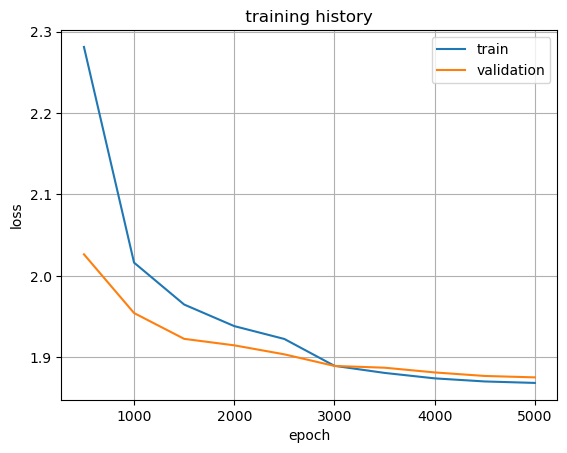

In [88]:
plt.plot(step,train_loss,label='train')
plt.plot(step,val_loss, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel("loss")
plt.title(" training history ")
plt.grid(visible=True)


In [100]:
val_r1 = [record["eval_rouge1"] for record in history[1:-2:2]]
val_r2 = [record["eval_rouge2"] for record in history[1:-2:2]]
val_rL = [record["eval_rougeL"] for record in history[1:-2:2]]
val_rLsum = [record["eval_rougeLsum"] for record in history[1:-2:2]]

val_rouge = {
    "eval_rouge1":val_r1,
    "eval_rouge2":val_r2,
    "eval_rougeL":val_rL,
    "eval_rougeLsum":val_rLsum
}

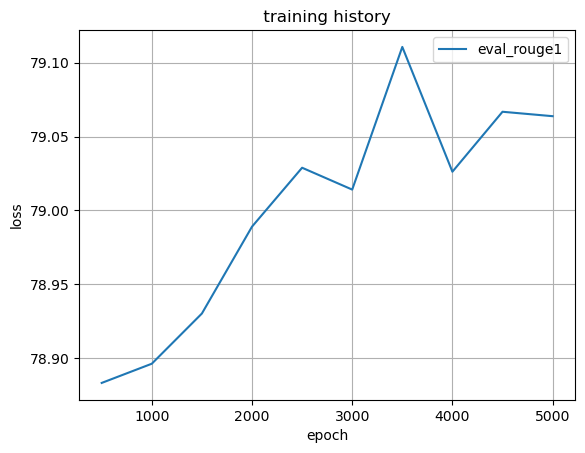

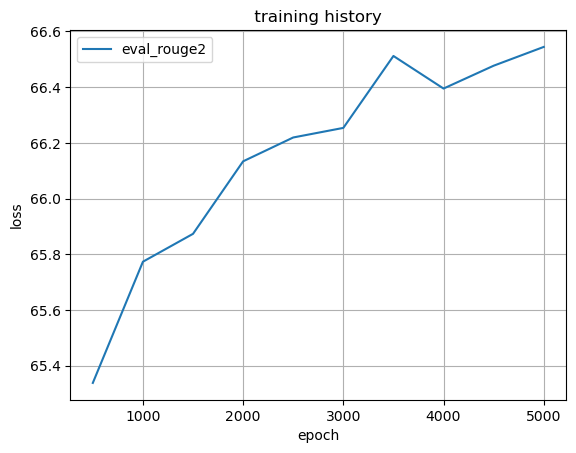

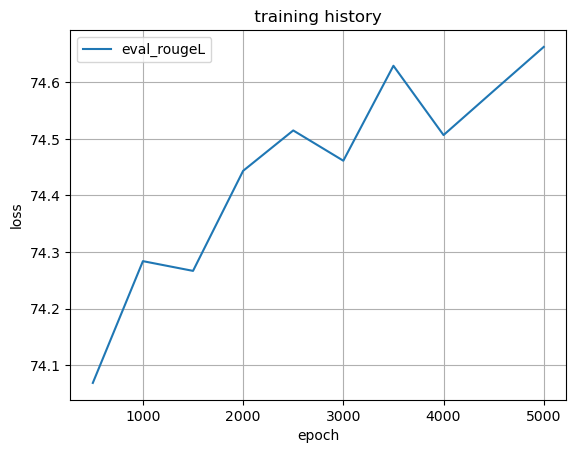

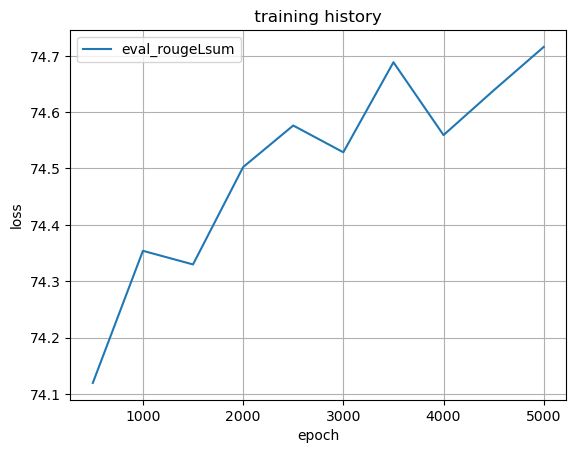

In [101]:
for name,val in val_rouge.items():
    plt.figure()
    plt.plot(step,val,label=name)
    # plt.plot(step,val_r2,label='rouge2')
    # plt.plot(step,val_rL,label='rougeL')
    # plt.plot(step,val_rLsum,label='rougeLsum')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel("loss")
    plt.title(" training history ")
    plt.grid(visible=True)

In [27]:
# test_set = datasets.load_dataset("paws", "labeled_final", split=["test"])
# test_set[0]

In [28]:
# gen_sents = generate_paraphrase(test_set[0], model)

In [29]:
# trainer.push_to_hub()